<b>Preparation</b>

In [3]:
!pip install pydicom
!pip install trimesh
!python -m pip install pymeshlab

import os # for file-handling
import numpy as np # maths
import matplotlib.pyplot as plt # plotting
from pydicom import dcmread # reading DICOM files

You should consider upgrading via the 'C:\Users\nasta\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\nasta\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\nasta\anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
current_path=os.getcwd()
print(current_path)

C:\Users\nasta\Visualization\indirect volume visualization


<b>Loading the data file</b>

In [6]:
import zipfile
with zipfile.ZipFile("DICOM_Brain.zip","r") as zip_ref:
    zip_ref.extractall(current_path) 

<b>Reading the dicom images</b>

In [7]:
# Read a volume and convert to numpy array 
def read_dcm_volume(name):
    volume_img = []
    for file in sorted(os.listdir(name)):
        dcm_slice = dcmread(os.path.join(name, file))
        volume_img.append(dcm_slice.pixel_array)
    return np.transpose(np.array(volume_img),(1,2,0))


# Load the volume
dcm_volume = read_dcm_volume('DICOM_Brain')

<b>Plotting the dicom images</b>

(256, 256, 20)


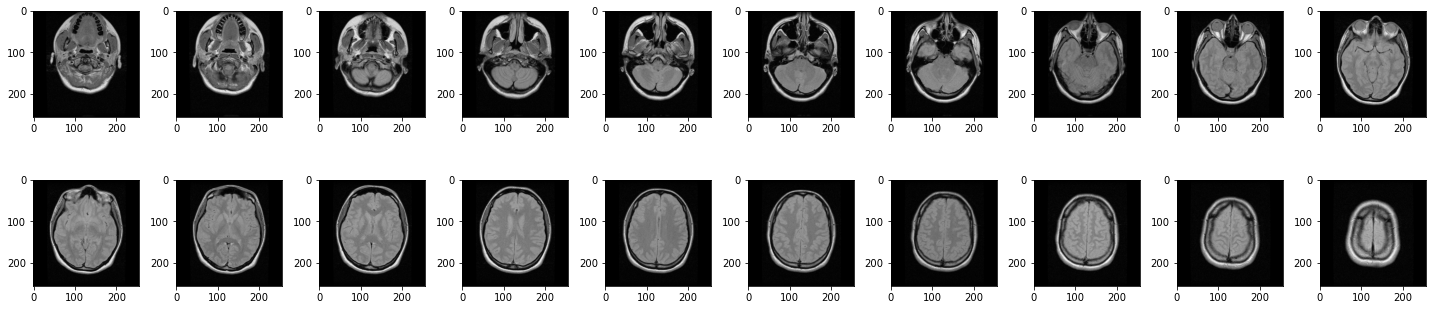

In [8]:
# Plot all slices in z-direction
fig = plt.figure(figsize=(20, 5))
print(dcm_volume.shape)
columns = int(dcm_volume.shape[2]/2) #10
rows = 2 
for i in range(1, int(columns*rows +1)): # 1 to 20
    img = dcm_volume[:,:,i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.tight_layout()
plt.show()

<b>Using the Marching Cubes algorithm to generate an indirect volume visualization (surface model) of the data set.</b>

In [9]:
from skimage import measure


############################################
# Perform the marching cubes algorithm here
############################################


# Adjust scale (medical data is often anisotropic --> the spacing in z-direction is different from the spacing in x- and -direction)
# We do this by multiplying the vertice positions in x, y, and z direction with the correct spacing factor
# If you skip this step, the plots will show you a distorted model
# Replace "verts" with the variable name you use for your vertices!
verts, faces, normals, values = measure.marching_cubes(dcm_volume, 256)

verts[:,0] *= 0.859375
verts[:,1] *= 0.859375
verts[:,2] *= 7

<b>Perform a mesh decimation to make the process faster by using Clustering Decimation from PyMeshLab. </b>

In [11]:
import pymeshlab
#################################
# Perform a mesh decimation here
#################################
# create a new Mesh with the two arrays
#def decimate_mesh(verts,faces):
m = pymeshlab.Mesh(verts, faces)


# create a new MeshSet
ms = pymeshlab.MeshSet()

# add the mesh to the MeshSet
ms.add_mesh(m, "cube_mesh")
ms.apply_filter('meshing_decimation_clustering')

# get a reference to the current mesh
m = ms.current_mesh()

# get numpy arrays of vertices and faces of the current mesh
v_matrix = m.vertex_matrix()
f_matrix = m.face_matrix()
#return v_matrix, f_matrix

#v_matrix_1, f_matrix_1=decimate_mesh(verts,faces)
#v_matrix_2, f_matrix_2=decimate_mesh(v_matrix_1,f_matrix_1)
#v_matrix_3, f_matrix_3=decimate_mesh(v_matrix_2,f_matrix_2)

###########################################################################################
m2 = pymeshlab.Mesh(v_matrix, f_matrix)


# create a new MeshSet
ms2 = pymeshlab.MeshSet()

# add the mesh to the MeshSet
ms2.add_mesh(m2, "cube_mesh")
ms2.apply_filter('meshing_decimation_clustering')

# get a reference to the current mesh
m2 = ms2.current_mesh()

# get numpy arrays of vertices and faces of the current mesh
v_matrix2 = m2.vertex_matrix()
f_matrix2 = m2.face_matrix()

<b>Apply colormaps based on normal direction</b>

In [13]:
from scipy.spatial.distance import cosine

def apply_color_map(mesh, current_cmap, flip_cm=False):
  face_normals = mesh.face_normal_matrix()
  target_vector = np.array([-0.8,0,1])
  face_colors = []
  vals = []
  maxval = 0
  for i in face_normals:
    val = abs(cosine((i+1)/2, target_vector))
    vals.append(val)
    maxval = max(maxval, val)

  for val in vals:
    if flip_cm: # flip when cmap starts bright
      face_colors.append(current_cmap(1-val/maxval)) # apply colorscale
    else:
      face_colors.append(current_cmap(val/maxval))  
  return face_colors

<b>Laplacian Smoothing</b>

(43483, 3)
(92925, 3)
[25683 25693 13870]
[11918 20219   897]
2
[12015 25804   897]
2
[11918   897 25804]
1
[20219   911   897]
2
[  897   911 20203]
0
[  897 20203   887]
0
[12015   897   887]
1


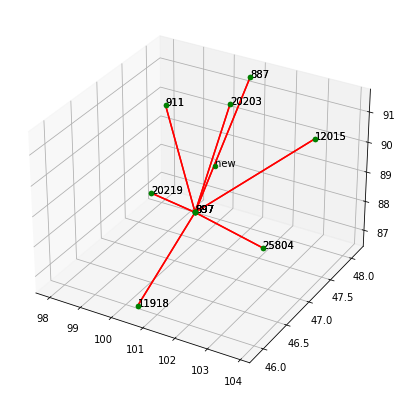

In [16]:
import numpy as np
############################################
# Identify the neighbors of each vertice and
# save them in a fitting data structure.
############################################
## an example to show how the code works########################################
print(v_matrix.shape)
print(f_matrix.shape)
print(f_matrix[0])
v=897       # as an example
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
#for v in v_matrix.shape[0]:
x_neighbours=[]
y_neighbours=[]
z_neighbours=[]
for f in range(f_matrix2.shape[0]):
  if v in f_matrix2[f]:
    print(f_matrix2[f])
    where=np.where(f_matrix2[f]==v)[0][0]
    print(where)
    for i in range(3):
      ax.scatter3D(v_matrix2[f_matrix2[f]][i][0], v_matrix2[f_matrix2[f]][i][1], v_matrix2[f_matrix2[f]][i][2], color = "green")
      ax.text(v_matrix2[f_matrix2[f]][i][0], v_matrix2[f_matrix2[f]][i][1], v_matrix2[f_matrix2[f]][i][2], str(f_matrix2[f][i]))
      x=[v_matrix2[f_matrix2[f][where]][0]]
      y=[v_matrix2[f_matrix2[f][where]][1]]
      z=[v_matrix2[f_matrix2[f][where]][2]]
      x.append(v_matrix2[f_matrix2[f]][i][0])
      y.append(v_matrix2[f_matrix2[f]][i][1])
      z.append(v_matrix2[f_matrix2[f]][i][2])
      plt.plot(x,y,z,color='red')
      if i != where:
        x_neighbours.append(v_matrix2[f_matrix2[f]][i][0])
        y_neighbours.append(v_matrix2[f_matrix2[f]][i][1])
        z_neighbours.append(v_matrix2[f_matrix2[f]][i][2])
x_mean=np.mean(x_neighbours)
y_mean=np.mean(y_neighbours)
z_mean=np.mean(z_neighbours)

ax.scatter3D(x_mean, y_mean, z_mean, color = "green")
ax.text(x_mean, y_mean, z_mean, "new ")
plt.show()

In [17]:

from sklearn.neighbors import NearestNeighbors
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm
import matplotlib.pyplot as plt


#example dataset
coords_vect = np.vstack([v_matrix[:,0], v_matrix[:,1], v_matrix[:,2]]).T 
print(coords_vect.shape) # 3 coordinates for each vertex

knn = NearestNeighbors(n_neighbors=3)
knn.fit(coords_vect)
distance_mat, neighbours_mat = knn.kneighbors(coords_vect)

print(neighbours_mat.shape) # number of three neighbours for each vertex
print(distance_mat.shape) # distance of three neighbours coordinates with each vertex

print(neighbours_mat)
type(neighbours_mat)
neighbours_mat[1:3]
# [mean(i) for i in neighbours_mat[]]
neighbours_mat[0, 0]

test = []

(43483, 3)
(43483, 3)
(43483, 3)
[[    0 38862 10899]
 [    1  1378 38790]
 [    2  1256  1559]
 ...
 [43480 43482 43461]
 [43481 43435 43474]
 [43482 43461 43480]]


In [18]:
#@title (b) Laplacian Smoothing

############################################
# Replace the position of each vertice with 
# the mean of the positions of its neighbors.
############################################
for x in range(len(v_matrix)): #for each vertex
  coord_neighbours = v_matrix[[neighbours_mat[x, 0], neighbours_mat[x, 1], neighbours_mat[x, 2]]] #the coordinates of 3 neighbours of each vertex
  mean_neighbours = [coord_neighbours[:, 0].mean(), coord_neighbours[:, 1].mean(), coord_neighbours[:, 2].mean()] # mean x, mean y , mean z of the neighbours
  test.append(mean_neighbours)

print(test[0]) 

[142.32879164039514, 65.2494647173182, 24.12705614868459]


In [19]:
face_colors = apply_color_map(m, cm.get_cmap('Oranges', 8), True)

<b>Visualization of the results</b>

C:\Users\nasta\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\nasta\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


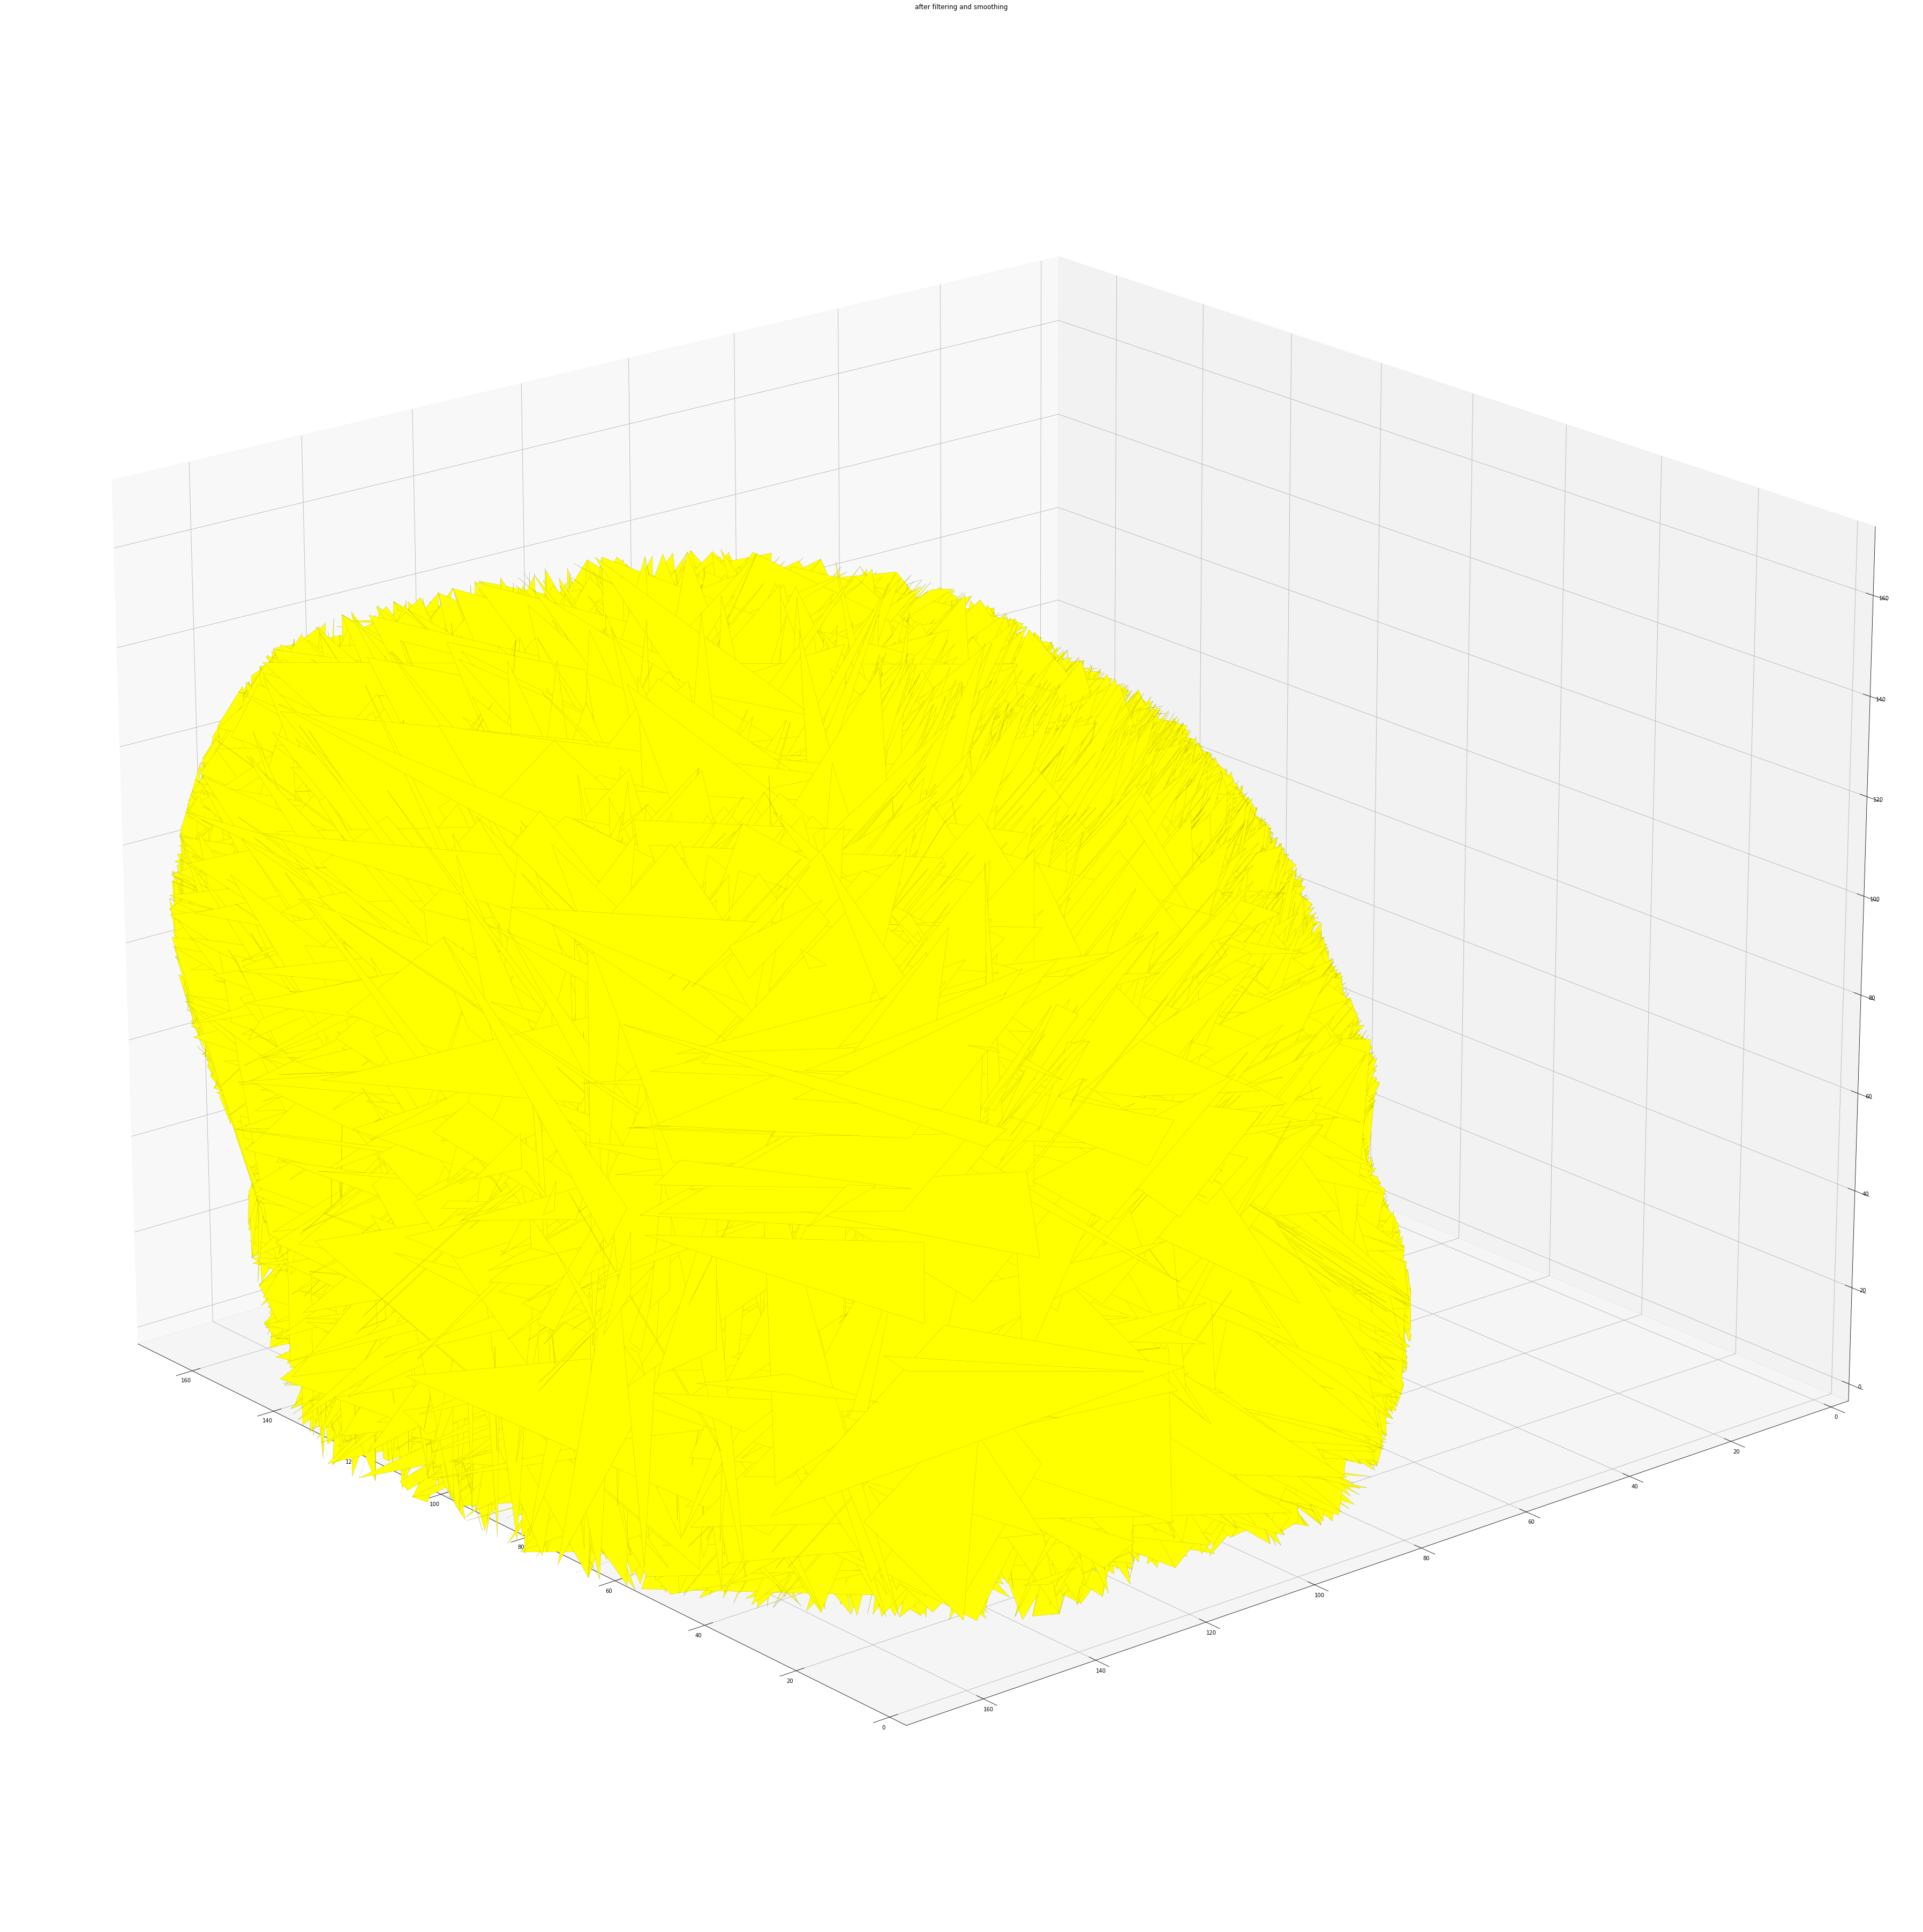

In [21]:
#@title Visualize the result
#@markdown You can use this code to visualize you result. Don't forget to insert the correct variable names for your vertices and faces in this code block.

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm

#laplace_verts = laplacian_smooth(filtered_verts.copy(), filtered_faces.copy(), 5)

# Mesh color
face_colors = 'yellow'
# Instead you can apply this color map:
# Recommended only for the decimated mesh.

#face_colors = apply_color_map(m, cm.get_cmap('Oranges', 8), True)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).


##############################################
# Replace "laplace_verts" and "filtered_faces" 
# with the correct variable names
##############################################

# Fancy indexing: `verts[faces]` to generate a collection of triangles
#mesh = Poly3DCollection(laplace_verts[filtered_faces],linewidth=0.1,edgecolor="k",facecolor = face_colors,rasterized=True)

###new verts is created########
fig = plt.figure(figsize=(100, 100))
ax = fig.add_subplot(211, projection='3d')
#face_colors = apply_color_map(m, cm.get_cmap('Oranges', 8), True)
############################################
# Replace "verts" and "faces" 
# with the correct variable names
############################################

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(test,linewidth=0.1,edgecolor="k",facecolor = face_colors,rasterized=True)
ax.add_collection3d(mesh)

# axis limits
ax.set_xlim(0, 170)
ax.set_ylim(0, 170)
ax.set_zlim(0, 170)
ax.set_title('after filtering and smoothing')
# viewing angle
ax.view_init(20, 140)

plt.tight_layout()
plt.show()